# Experiment 3.1

Initial benchmark on EED data set 

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import matplotlib
matplotlib.rcParams.update({'font.size': 22})

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['figure.dpi'] = 300

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('tableau-colorblind10')

# Retrieve color cycle from ggplot style
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

#print(colors)

# Map models to specific colors
color_map = {'iTransformer': colors[0], 'PatchTST': colors[1], 'Autoformer': colors[2], 'Informer': colors[3], 'Transformer': colors[4], 
             'TSMixer': colors[5], 'DLinear': colors[6], 'LSTM': colors[7], 
             'XGBoost': colors[8], 'Linear Regression': colors[9], 'Ridge Regression': colors[9]}

%pwd

'/Users/timw/Documents/University/thesis_2/scripts/Exp3.1_default_benchmark_EED'

In [40]:
targets = ["multi", "load", "solar", "wind"] 
horizons = ['24', '96', '192', '336', '720']  
models = ['iTransformer', 'Transformer', "LSTM", "XGBoost", "Linear Regression"]
metrics = ['MSE', 'MAE']  

## Import data and plot all benchmark results

In [41]:
idx = pd.IndexSlice
benchmark_table = pd.read_csv("./../../results/benchmark_table_Exp3.1_metrics.csv", header=[0, 1], index_col=[0, 1]).loc['multi', idx[models, :]].replace('-', np.nan).astype(float)
benchmark_table2 = pd.read_csv("./../../results/benchmark_table_Exp3.1.1_metrics.csv", header=[0, 1], index_col=[0, 1]).loc['multi', idx['Linear Regression', :]].replace('-', np.nan).astype(float)
epoch_time_table = pd.read_csv("./../../results/benchmark_table_Exp3.1_epoch_time.csv", header=[0, 1], index_col=[0, 1]).loc['multi', idx[models, :]].replace('-', np.nan).astype(float)
modelsize_maxmemory_table = pd.read_csv("./../../results/benchmark_table_Exp3.1_modelsize_maxmemory.csv", header=[0, 1], index_col=[0, 1]).loc['multi', idx[models, :]].replace('-', np.nan).astype(float)

benchmark_table2 = benchmark_table2.rename(columns={"Linear Regression": "Ridge Regression"})
benchmark_table = pd.concat((benchmark_table, benchmark_table2), axis=1)
models.append("Ridge Regression")
benchmark_table

Model   iTransformer         Transformer            LSTM         XGBoost  \
Metric           MSE     MAE         MSE     MAE     MSE     MAE     MSE   
Horizon                                                                    
24            0.1348  0.2214      0.0633  0.1707  0.0687  0.1796  0.0665   
96            0.2071  0.2871      0.0731  0.1822  0.0955  0.2155  0.0811   
192           0.2521  0.3251      0.0692  0.1734  0.1098  0.2322  0.0858   
336           0.2913  0.3501      0.0693  0.1751  0.1089  0.2313  0.0929   
720           0.3331  0.3787      0.0743  0.1854  0.1106  0.2340  0.1246   

Model           Linear Regression         Ridge Regression          
Metric      MAE               MSE     MAE              MSE     MAE  
Horizon                                                             
24       0.1586            0.9462  0.3685           0.1852  0.2920  
96       0.1801            3.3390  0.5143           0.2908  0.3695  
192      0.1855            3.2563  0.5477           0.3418  0.4039  
336      0.1942            3.5071  0.6051           0.4101  0.4507  
720      0.2273            6.1105  0.7601           0.5708  0.5438

# Plot again but highlight best value

In [42]:
def highlight_min(s):
    '''
    Highlight the minimum in a Series green.
    '''
    s_mse = s.xs("MSE", axis=0, level=1)
    is_min_mse = s_mse == s_mse.min()
    s_mae = s.xs("MAE", axis=0, level=1)
    is_min_mae = s_mae == s_mae.min()

    is_min = s.copy()
    
    is_min.loc[:,"MSE"] = is_min_mse.values
    is_min.loc[:,"MAE"] = is_min_mae.values

    return ['background-color: green' if v else '' for v in is_min]

styled_df = benchmark_table.style.apply(highlight_min, axis=1)
styled_df

/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_86282/81131224.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True False False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  is_min.loc[:,"MSE"] = is_min_mse.values


In [43]:
# Calculate the number of times a model has been the best model
MSE_values = benchmark_table.xs("MSE", axis=1, level=1)
MAE_values = benchmark_table.xs("MAE", axis=1, level=1)
models_min_MSE = MSE_values.min(axis=1)
models_min_MAE = MAE_values.min(axis=1)
counter = {model: 0 for model in models if model != "Dummy"}

for i, row in enumerate(MSE_values.iterrows()):
    best_models = row[1][row[1] == models_min_MSE.iloc[i]].index
    for model in best_models:
        counter[model] +=1

for i, row in enumerate(MAE_values.iterrows()):
    best_models = row[1][row[1] == models_min_MAE.iloc[i]].index
    for model in best_models:
        counter[model] +=1

best_model_counter = pd.Series(counter)
print(best_model_counter)



#iTransformer:  7, 7
#PatchTST:      8, 6
#Autoformer:    0, 0
#Informer:      3, 3
#Transformer:   4, 4

#TSMixer:       2, 2
#DLinear:       8, 1
#LSTM           4, 0
#XGBoost:       8, 4
#LR:            5, 0

#Insgesamt: 40, 20

iTransformer         0
Transformer          8
LSTM                 0
XGBoost              2
Linear Regression    0
Ridge Regression     0
dtype: int64


In [44]:
skill_table = 1 - benchmark_table / benchmark_table.xs("Ridge Regression", level=0, axis=1)
avgs = skill_table.mean(axis=0)
# Mean over all Metrics (level =1, axis=0)
#print(avg)
imp_over_lr = (avgs.xs("MAE", level=1, axis=0) + avgs.xs("MSE", level=1, axis=0)) / 2 * 100
print(round(imp_over_lr))

Model
iTransformer          27.0
Transformer           67.0
LSTM                  58.0
XGBoost               63.0
Linear Regression   -421.0
Ridge Regression       0.0
dtype: float64


In [45]:
##print(benchmark_table.sum(axis=0))
#avg = benchmark_table.sum(axis=0)/benchmark_table.shape[0]
##print(avg_without_wind)
##stds = epoch_time_table.std(axis=0)
#
##print(averages)
##print(stds)
#avg_mse = avg.loc[pd.IndexSlice[:, 'MSE']]
#
#
##std1 = stds.loc[pd.IndexSlice[:, 'MSE']]
##print(pd.concat((averages1,std1), axis=1))
##print(averages1)
#
#avg_mae = avg.loc[pd.IndexSlice[:, 'MAE']]
##std2 = stds.loc[pd.IndexSlice[:, 'time[min]']]
##print(pd.concat((averages2,std2), axis=1))
##print(averages2)
#
#avg = (avg_mse + avg_mae) / 2
##print(avg)
#imp_over_lr = round((1- (avg / avg.loc["Ridge Regression"])) * 100)
#
##print(avg)
##print(avg_without_wind)
#print("Improvement over Ridge Regression")
#print(imp_over_lr)
#print("\n")


In [46]:
imp_over_lr.to_latex("./../../results/benchmark_table_Exp3.1_metrics_impr.tex")
#best_model_counter.to_latex("./../../results/benchmark_table_Exp1_metrics_best_model_counter.tex")

## Epochs and time needed for training

In [47]:
epoch_time_table

Model   iTransformer           Transformer             LSTM           XGBoost  \
Metric        epochs time[min]      epochs time[min] epochs time[min]  epochs   
Horizon                                                                         
24              12.0       6.0        17.0      20.0   12.0       5.0     NaN   
96              11.0       6.0        15.0      23.0   10.0       6.0     NaN   
192             10.0       6.0        10.0      46.0    9.0       6.0     NaN   
336             23.0      16.0        13.0      79.0   10.0       8.0     NaN   
720             15.0      14.0        11.0      99.0   11.0      15.0     NaN   

Model             Linear Regression            
Metric  time[min]            epochs time[min]  
Horizon                                        
24           11.0               NaN       1.0  
96           83.0               NaN       4.0  
192         111.0               NaN       4.0  
336          95.0               NaN       3.0  
720          85.0               NaN       3.0

In [48]:
averages = (epoch_time_table.sum(axis=0)/epoch_time_table.shape[0])
stds = epoch_time_table.std(axis=0)

#print(averages)
#print(stds)
averages1 = averages.loc[pd.IndexSlice[:, 'epochs']]
std1 = stds.loc[pd.IndexSlice[:, 'epochs']]
print("Average number of epochs and standard deviation")
print(pd.concat((averages1,std1), axis=1))
print("\n")

averages2 = averages.loc[pd.IndexSlice[:, 'time[min]']]
std2 = stds.loc[pd.IndexSlice[:, 'time[min]']]
print("Average training time[min] and standard deviation")
print(pd.concat((averages2,std2), axis=1))

Average number of epochs and standard deviation
                      0         1
Model                            
iTransformer       14.2  5.263079
Transformer        13.2  2.863564
LSTM               10.4  1.140175
XGBoost             0.0       NaN
Linear Regression   0.0       NaN


Average training time[min] and standard deviation
                      0          1
Model                             
iTransformer        9.6   4.979960
Transformer        53.4  34.746223
LSTM                8.0   4.062019
XGBoost            77.0  38.522721
Linear Regression   3.0   1.224745


# Modelsize and Memory

In [49]:
modelsize_maxmemory_table

Model   iTransformer              Transformer                     LSTM  \
Metric  params[Mio.] max_mem[MB] params[Mio.] max_mem[MB] params[Mio.]   
Horizon                                                                  
24               1.3       296.0          1.4      4078.0          8.5   
96               1.3       301.0          1.4      5026.0          8.5   
192              1.4       305.0         11.1     15530.0          8.5   
336              1.4       317.0         11.1     21356.0          8.5   
720              5.6       562.0          9.3     31726.0          8.5   

Model                    XGBoost             Linear Regression              
Metric  max_mem[MB] params[Mio.] max_mem[MB]      params[Mio.] max_mem[MB]  
Horizon                                                                     
24            441.0          NaN         0.0               NaN         NaN  
96            584.0          NaN         0.0               NaN         NaN  
192           848.0          NaN         0.0               NaN         NaN  
336          1212.0          NaN         0.0               NaN         NaN  
720          2092.0          NaN         0.0               NaN         NaN

In [50]:
averages = (modelsize_maxmemory_table.sum(axis=0)/modelsize_maxmemory_table.shape[0])
stds = modelsize_maxmemory_table.std(axis=0)

#print(averages)
#print(stds)
averages1 = round(averages.loc[pd.IndexSlice[:, 'params[Mio.]']],1)
std1 = round(stds.loc[pd.IndexSlice[:, 'params[Mio.]']],1)
print("Average number of parameters[Mio.] and standard deviation")
print(pd.concat((averages1,std1), axis=1))

averages2 = round(averages.loc[pd.IndexSlice[:, 'max_mem[MB]']],1)
std2 = round(stds.loc[pd.IndexSlice[:, 'max_mem[MB]']],1)
print("\n")
print("Average maximum memory[MB] and standard deviation")
print(pd.concat((averages2,std2), axis=1))

Average number of parameters[Mio.] and standard deviation
                     0    1
Model                      
iTransformer       2.2  1.9
Transformer        6.9  5.0
LSTM               8.5  0.0
XGBoost            0.0  NaN
Linear Regression  0.0  NaN


Average maximum memory[MB] and standard deviation
                         0        1
Model                              
iTransformer         356.2    115.3
Transformer        15543.2  11594.5
LSTM                1035.4    659.5
XGBoost                0.0      0.0
Linear Regression      0.0      NaN


In [51]:
benchmark_table

Model   iTransformer         Transformer            LSTM         XGBoost  \
Metric           MSE     MAE         MSE     MAE     MSE     MAE     MSE   
Horizon                                                                    
24            0.1348  0.2214      0.0633  0.1707  0.0687  0.1796  0.0665   
96            0.2071  0.2871      0.0731  0.1822  0.0955  0.2155  0.0811   
192           0.2521  0.3251      0.0692  0.1734  0.1098  0.2322  0.0858   
336           0.2913  0.3501      0.0693  0.1751  0.1089  0.2313  0.0929   
720           0.3331  0.3787      0.0743  0.1854  0.1106  0.2340  0.1246   

Model           Linear Regression         Ridge Regression          
Metric      MAE               MSE     MAE              MSE     MAE  
Horizon                                                             
24       0.1586            0.9462  0.3685           0.1852  0.2920  
96       0.1801            3.3390  0.5143           0.2908  0.3695  
192      0.1855            3.2563  0.5477           0.3418  0.4039  
336      0.1942            3.5071  0.6051           0.4101  0.4507  
720      0.2273            6.1105  0.7601           0.5708  0.5438

In [52]:
#Save to latex
formatted_df= benchmark_table.round(3)
formatted_df = formatted_df.applymap(lambda x: f'{x:.3f}' if isinstance(x, (float, int)) else x)
formatted_df.to_latex("./../../results/benchmark_table_Exp3.1_metrics.tex")

/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_86282/1188389363.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df = formatted_df.applymap(lambda x: f'{x:.3f}' if isinstance(x, (float, int)) else x)


# Visualization of benchmark

In [53]:
bms = []
bms_et = []

benchmark_table.drop(columns=["Linear Regression"], inplace=True)
models.remove("Linear Regression")
bm_mse = benchmark_table.xs('MSE', level=1, axis=1)
bm_mae = benchmark_table.xs('MAE', level=1, axis=1)
bms.append((bm_mse, bm_mae))


/var/folders/m4/89q121bx0sxd404czvsn99kh0000gn/T/ipykernel_86282/118972766.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  benchmark_table.drop(columns=["Linear Regression"], inplace=True)


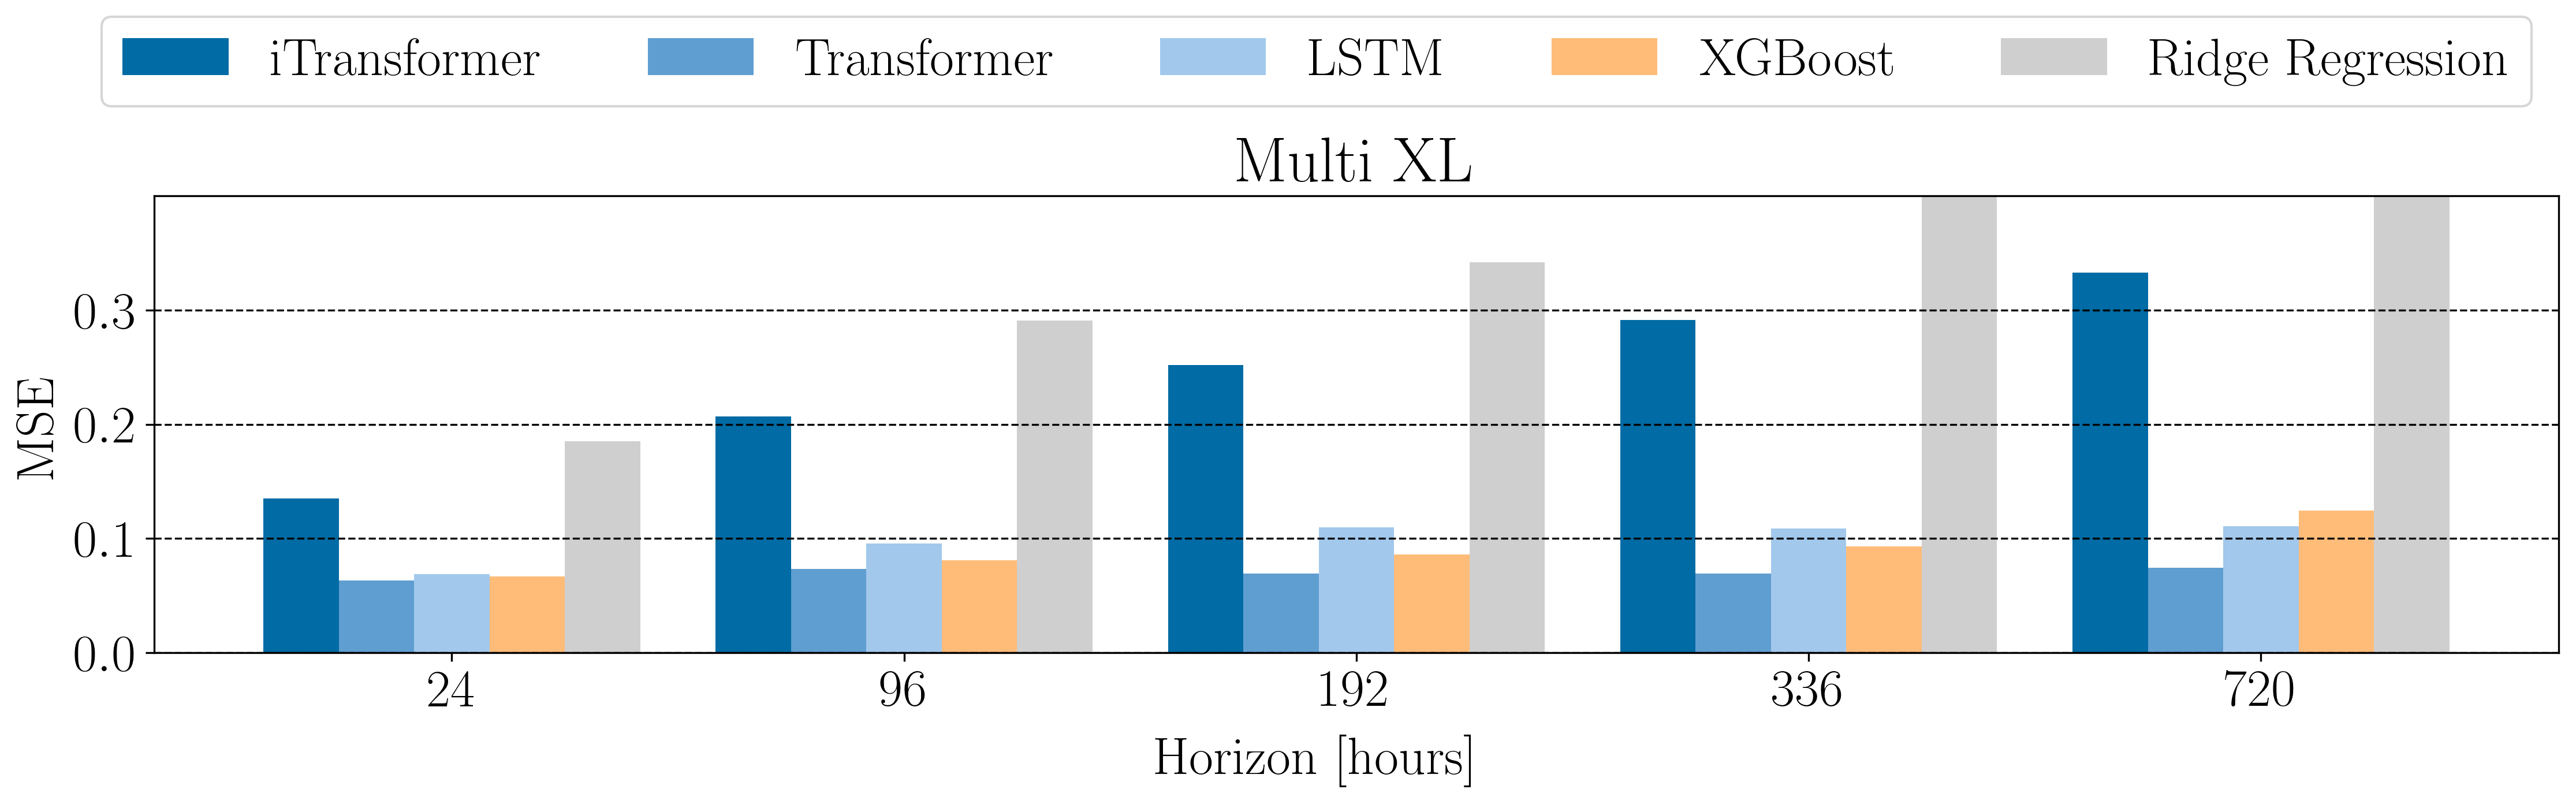

In [54]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(15, 4))  # Adjusted size for better visibility of bars

# Example colors for the models
#colors = ["#1f77b4", "#17becf", "#2ca02c", "#e377c2", "#bcbd22", "#7f7f7f"]

# Example data
# Assuming each bm_mse for each i is a DataFrame where columns are models and rows are horizons
for i, (bm_mse, bm_mae) in enumerate(bms):
    bar_width = 1 / (len(bm_mse.columns) + 1)  # Width of each bar, adjusted for number of models

    for j, model in enumerate(bm_mse.columns):
        # Position of each bar grouped by horizon
        positions = np.arange(bm_mse.shape[0]) + j * bar_width

        # Plotting the bar for each model at each horizon
        ax.bar(positions, bm_mse[model], width=bar_width, color=color_map[model], label=model if i == 0 else "")

    ax.set_title('Multi XL')
    ax.set_xticks(np.arange(bm_mse.shape[0]) + bar_width * (len(bm_mse.columns) - 1) / 2)  # Setting x-ticks to be at the center of the group
    ax.set_xticklabels([f'{x}' for x in horizons])  # Assuming horizons are like 0h, 1h, etc.
    #ax[i].set_xlabel('Horizon [hours]')
    ax.grid(True, axis='y', color='black', linestyle='--')
    ax.set_ylim(0, 0.4)
    ax.set_yticks(np.arange(0, 0.4, 0.1))


#f.legend(loc='upper')  # Only one legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=10)

fig.text(0.5, 0, 'Horizon [hours]', ha='center')
fig.text(0, 0.5, 'MSE', va='center', rotation='vertical')
fig.tight_layout()
plt.show()
